In [1]:
import pickle
import pandas as pd
import numpy as np
import math

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import boto3
import botocore
import edn_format as edn
import scipy.sparse as sp
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline

# Load in Prime Attribute Mapping

In [2]:
def read_s3_file(bucket_name: str, key: str):
    session = boto3.Session(profile_name='dev')
    s3conn = session.resource('s3')

    a_file = s3conn.Object(bucket_name, key)
    return a_file.get()['Body'].read().decode('UTF-8')

def get_latest_model_params_from_s3(bucket_name: str, s3_key: str):
    try:
        model_params = read_s3_file(bucket_name=bucket_name, key=s3_key)
        return dict(edn.loads(model_params))
    except:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        lines = traceback.format_exception(exc_type, exc_value, exc_traceback)
        print("Unexpected error: {}".format(''.join(lines)))
        return None

In [3]:
S3_BUCKET_NAME = "roktoptimus"
S3_KEY = "optimus_params/0.3/rokt_optimus_model_params_2017_09_06_07_05_29_UTC.edn"
prior_params = get_latest_model_params_from_s3(bucket_name=S3_BUCKET_NAME, s3_key=S3_KEY)

# Load in Data for non-prime model

In [4]:
_path = "/Users/xuyan/Documents/workspace/optimus/src/training_non_prime_C_2017-09-08 02:22:00.777244+00:00.pkl"

model_training = pickle.load(open(_path, 'rb'))
model_training_pd = pd.DataFrame.from_records(model_training['X'])
model_training_pd['true_y'] = pd.to_numeric(model_training['y'])
model_training_pd['pred_y'] = model_training['y_pred']

In [16]:
group_by_columns = ['agegroup','deviceplatform','engagementofferid','gender','publisherwidgetgroupid','publisherwidgetid','repeatvisitor']
model_training_groupby_pd = model_training_pd.groupby(group_by_columns).agg({'true_y' : ['mean', 'count']})
model_training_groupby_pd.columns = ["_".join(x) for x in model_training_groupby_pd.columns.ravel()]
model_training_groupby_pd.reset_index(inplace=True)
model_training_groupby_pd = model_training_groupby_pd[model_training_groupby_pd['engagementofferid'] > 0]

In [50]:
model_training_groupby_pd.head(3)

agegroup  deviceplatform    engagementofferid gender  \
65         0               1  2354207961775908156      f   
65         0               1  2354207961775908156      f   
65         0               1  2354207961775908156      f   

    publisherwidgetgroupid  publisherwidgetid  repeatvisitor  true_y_mean  \
65                     766               5917              0     4.429791   
65                     766               5917              0     4.429791   
65                     766               5917              0     4.429791   

    true_y_count  
65           295  
65           295  
65           295

In [25]:
model_training_groupby_pd.shape

(17022, 9)

# Empirical Model

In [44]:
# group_by_columns_model = ['engagementofferid','publisherwidgetid','repeatvisitor']
group_by_columns_model = ['engagementofferid','publisherwidgetid']
empirical_model_pd = model_training_pd.groupby(group_by_columns_model).agg({'true_y' : ['mean', 'count']})
empirical_model_pd.columns = ["_".join(x) for x in empirical_model_pd.columns.ravel()]
empirical_model_pd.reset_index(inplace=True)

In [45]:
empirical_model_pd.shape

(1484, 4)

In [46]:
temp_df = pd.merge(model_training_groupby_pd, empirical_model_pd,  how='left', on=group_by_columns_model, suffixes=('_left', '_right'))
temp_df.head()

agegroup  deviceplatform    engagementofferid gender  \
0         0               1  2354207961775908156      f   
1         0               1  2354207961775908156      f   
2         0               1  2354207961775908156      m   
3         0               1  2354207961775908156      m   
4         0               1  2354250980168364187          

   publisherwidgetgroupid  publisherwidgetid  repeatvisitor  true_y_mean_left  \
0                     766               5917              0          4.429791   
1                     766               5917              1         10.279283   
2                     766               5917              0          8.400268   
3                     766               5917              1        119.630013   
4                       0               5980              0          2.594537   

   true_y_count_left  true_y_mean_right  true_y_count_right  
0                295           6.216796                1577  
1                  2           6.216796                1577  
2                305           6.216796                1577  
3                  2           6.216796                1577  
4                  4           2.202065                  41

### Accuracy

In [47]:
A = temp_df['true_y_mean_left'].values
B = temp_df['true_y_mean_right'].values

print("mean_absolute_error:", metrics.mean_absolute_error(A, B))
print("r2_score:", metrics.r2_score(A, B))

mean_absolute_error: 1.19906936949
r2_score: 0.198707571255


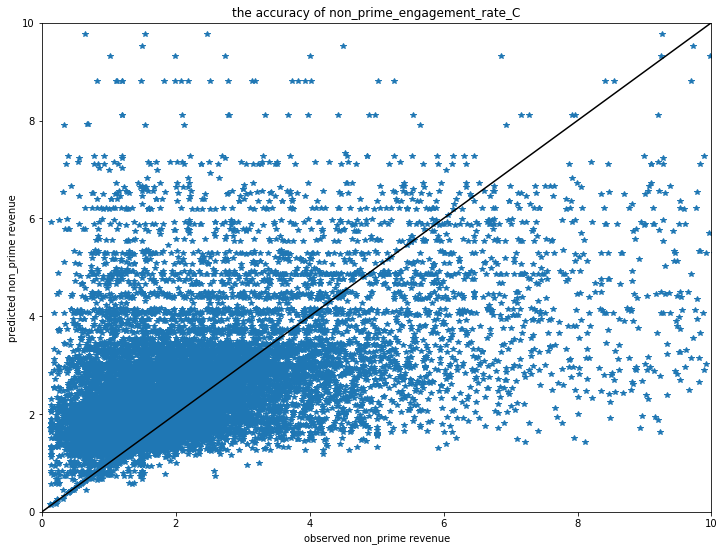

In [48]:
plt.figure(figsize = (12,9))
plt.plot(A, B, '*')
plt.plot([0, 10], [0, 10], 'k-')
plt.axis([0, 10, 0, 10])
plt.xlabel("observed non_prime revenue")
plt.ylabel("predicted non_prime revenue")
plt.title("the accuracy of non_prime_engagement_rate_C")